### This model combines two branches: MobileNet and GRU. 

The Mobilenet branch is inspired by Beluga's kernel. We used Mobilenet since it simply has the highest accuracy rate among all public single kernal CNN models like VGG or ResNet. And the combination of CNN and RNN is based on this paper  *SketchMate: Deep Hashing for Million-Scale Human Sketch Retrieval*(Peng, Yongye) http://homepages.inf.ed.ac.uk/thospeda/papers/xu2018sketchHash.pdf. 


### Import packages

In [0]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate
from keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from ast import literal_eval
from keras.preprocessing.sequence import pad_sequences


Using TensorFlow backend.


### Small functions

In [0]:

DP_DIR = '../input/shuffle-csvs/'
INPUT_DIR = '../input/quickdraw-doodle-recognition/'
BASE_SIZE = 256
NCSVS = 10
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [0]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

### Data Generator

In [0]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):#read the raw strokes data and output the nmupy matrix of image. And different strokes in this image were assigned different colors. 
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_ge(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing1'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing1.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = np.repeat(x, 3, axis =3)
                x = preprocess_input(x).astype(np.float32)
                
                df['drawing'] = df['drawing'].map(_stack_it)
                x2 = np.stack(df['drawing'], 0)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield [x, x2], y #Generate training data for two branchs.x is input for base model, x2 is input for GRU model

def df_to_img(df, size, lw=6, time_color=True): # prepare the test data
    df['drawing1'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    
    for i, raw_strokes in enumerate(df.drawing1.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = np.repeat(x, 3, axis =3)
    x = preprocess_input(x).astype(np.float32)
    df['drawing'] = df['drawing'].map(_stack_it)
    x2 = np.stack(df['drawing'], 0)
    return [x,x2]

## MobileNet branch

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)

In [0]:
STEPS = 800 
EPOCHS = 7 #Here we trained 7 epochs for our model.
size = 128
batchsize = 340

In [0]:
#create the base model, where we used MobileNet only 
base_model = MobileNet(input_shape=(size, size,3), alpha=1., weights="imagenet", include_top = False)
inp = base_model.input
x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dense(NCATS, activation='softmax')(x)
model = Model(inp, x)


In [0]:
base_model.summary() #show the layers, output size and number of params. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0         
__________

## Gated recurrent unit (GRU) branch

In [0]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, Dense, Dropout, Bidirectional, GRU, CuDNNGRU# this one is about 3x faster on GPU instances
inp = Input(shape = (70,3)) # size of input of RNN branch

x = BatchNormalization()(inp)

# # filter
x = Conv1D(256, (5,), activation = "relu")(x)
x = Dropout(0.2)(x)
x = Conv1D(256, (5,), activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Conv1D(256, (3,), activation = 'relu')(x)
x = Dropout(0.2)(x)


# The GRU architecture
x = Bidirectional(CuDNNGRU(128, return_sequences=True,  input_shape = x.shape))(x)
x = Dropout(0.2)(x)
x = Bidirectional(CuDNNGRU(128, return_sequences= False))(x)
x = Dropout(0.2)(x)

x = Dense(512, activation = 'relu')(x)
x = Dense(NCATS, activation='softmax')(x)
GRU_model = Model(inp,x)
GRU_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
GRU_model = Sequential(GRU_model.layers[:-1])
GRU_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 70, 3)             12        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 66, 256)           4096      
_________________________________________________________________
dropout_7 (Dropout)          (None, 66, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 62, 256)           327936    
_________________________________________________________________
dropout_8 (Dropout)          (None, 62, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 60, 256)           196864    
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 256)           0         
__________

### Combining two branches

In [0]:
inp = base_model.input
y = base_model.output
y = GlobalAveragePooling2D()(y)

inp2 = Input(shape = (70, 3))
z = stroke_read_model(inp2)
x = concatenate([y, z])
x = Dropout(0.3)(x)
x = Dense(NCATS, activation='softmax')(x)
model = Model([inp, inp2], x)#two inputs and one output

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

### GRU Preprocessing

In [0]:
def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=70, 
                         padding='post').swapaxes(0, 1)


### Prepare train and validating data

In [0]:
train_datagen = image_ge(size=size, batchsize=batchsize, ks=range(NCSVS - 1)) #generate train data
val_datagen = image_ge(size=size, batchsize=batchsize, ks=range(NCSVS - 1, NCSVS))#generate validation/test data

### First 7 epochs

In [0]:

hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=val_datagen, validation_steps = 100
)#training 7 epoch
hists.append(hist)

Epoch 1/7
800/800 [==============================] - 1089s 1s/step - loss: 1.7771 - categorical_crossentropy: 1.7771 - categorical_accuracy: 0.5782 - top_3_accuracy: 0.7678 - val_loss: 1.4684 - val_categorical_crossentropy: 1.4684 - val_categorical_accuracy: 0.6337 - val_top_3_accuracy: 0.8213
Epoch 2/7
800/800 [==============================] - 1068s 1s/step - loss: 1.2857 - categorical_crossentropy: 1.2857 - categorical_accuracy: 0.6769 - top_3_accuracy: 0.8537 - val_loss: 1.2299 - val_categorical_crossentropy: 1.2299 - val_categorical_accuracy: 0.6871 - val_top_3_accuracy: 0.8627
Epoch 3/7
800/800 [==============================] - 1070s 1s/step - loss: 1.1797 - categorical_crossentropy: 1.1797 - categorical_accuracy: 0.7017 - top_3_accuracy: 0.8690 - val_loss: 1.1716 - val_categorical_crossentropy: 1.1716 - val_categorical_accuracy: 0.7042 - val_top_3_accuracy: 0.8707
Epoch 4/7
800/800 [==============================] - 1067s 1s/step - loss: 1.1013 - categorical_crossentropy: 1.101

### Plot the accuracy and loss graphs

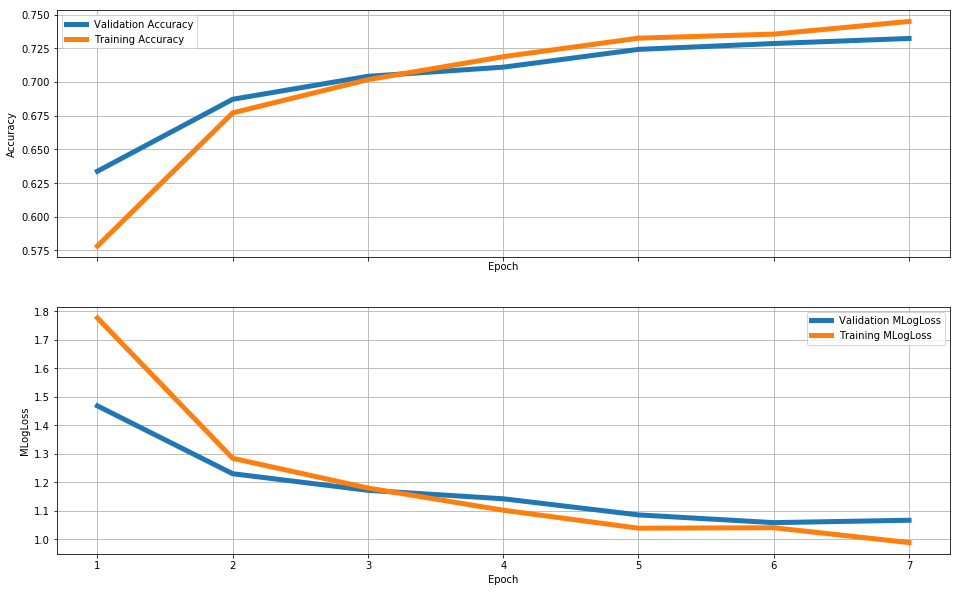

In [0]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();#The top graph shows the Training accuracy and Validation accuracy. The bottom graph shows the training loss and validation loss.

### Testing

In [0]:
df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS)), nrows=34000)# read 34000 rows of each shuffle data file we just created
for i in range(10):#
    valid_df = df.loc[i*3400:(i+1)*3400,:].copy()
    x_valid, x2 = df_to_img(valid_df, size)
    y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
    print(x_valid.shape, y_valid.shape)
    print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))
    valid_predictions = model.predict([x_valid, x2], batch_size=128, verbose=1)
    map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)

    print('Map3: {:.3f}'.format(map3))

(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 6s 2ms/step
Map3: 0.800
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.801
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.808
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.797
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.805
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.800
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.795
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/

#### *Creating Submission for the kaggle competition(a classification of the strokes data in test_simplified.csv)

In [0]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))

for i in range(10):
    end = min((i+1)*11220, 112199)
    subtest= test.iloc[i*11220:end].copy().reset_index(drop=True)
    x_test = df_to_img(subtest, size)

    test_predictions = model.predict(x_test, batch_size=128, verbose=1)

    top3 = preds2catids(test_predictions)
    cats = list_categories()
    id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
    top3cats = top3.replace(id2cat)
    subtest['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
    subtest.head()
    if i ==0:

        submission = subtest[['key_id', 'word']]
    else: 
        submission = submission.append(subtest[['key_id', 'word']], ignore_index=True)


SyntaxError: can't assign to operator (<ipython-input-26-8932661ad6ed>, line 18)

In [0]:
submission.to_csv('test.csv', index=False)
submission.head()
submission.shape